<a href="https://colab.research.google.com/github/saqlineniam/Small-Scale-Drone-Weed-Detection-using-Machine-Vision/blob/main/Small_weed_detection_using_RF_DETR_with_Mobinlenet_%2B_FPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q rfdetr supervision==0.26.1 roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 136.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = "/content/drive/MyDrive/weedcrop.v1i.coco-segmentation"

In [4]:
from rfdetr import RFDETRMedium
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_small
from torchvision.ops import FeaturePyramidNetwork
from collections import OrderedDict


In [5]:
class MobileNetV3FPNBackbone(nn.Module):
    """
    Lightweight FPN backbone using MobileNetV3-Small for efficient small object detection.
    Designed for weed detection with reduced model size (~80-100 MB vs 600+ MB).
    """
    def __init__(self, pretrained=True):
        super(MobileNetV3FPNBackbone, self).__init__()

        # Load pretrained MobileNetV3-Small with updated API
        print("Loading MobileNetV3-Small backbone...")
        from torchvision.models import MobileNet_V3_Small_Weights

        if pretrained:
            weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
            mobilenet = mobilenet_v3_small(weights=weights)
        else:
            mobilenet = mobilenet_v3_small(weights=None)
        self.features = mobilenet.features

        # MobileNetV3-Small has 13 stages (0-12)
        # We extract features at three scales for FPN:
        # Stage 3: Early features (24 channels)
        # Stage 5: Mid-level features (48 channels)
        # Stage 12: High-level features (576 channels)
        self.extract_indices = [3, 5, 12]
        self.in_channels_list = [24, 48, 576]

        # Feature Pyramid Network with 128 output channels
        # This maintains good feature representation while keeping model size reasonable
        print("Building FPN with 128 channels...")
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=self.in_channels_list,
            out_channels=128
        )

        # Project concatenated FPN features to RF-DETR's expected 256 channels
        # Input: 128 * 3 = 384 channels (P3 + P4 + P5)
        # Output: 256 channels for RF-DETR
        self.output_proj = nn.Sequential(
            nn.Conv2d(128 * 3, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        print("MobileNetV3-FPN backbone initialized!")
        print(f"Expected model size: ~80-100 MB")

    def forward(self, x):
        # Extract multi-scale features from MobileNetV3
        features = []
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i in self.extract_indices:
                features.append(x)

        c3, c4, c5 = features

        # Create OrderedDict for FPN
        feature_dict = OrderedDict([
            ('c3', c3),  # Low-level features (higher resolution)
            ('c4', c4),  # Mid-level features
            ('c5', c5)   # High-level features (lower resolution)
        ])

        # Apply FPN to create multi-scale feature pyramid
        fpn_features = self.fpn(feature_dict)

        # Extract FPN outputs
        p3 = fpn_features['c3']  # Finest scale (best for small objects)
        p4 = fpn_features['c4']  # Medium scale
        p5 = fpn_features['c5']  # Coarsest scale

        # Upsample P4 and P5 to match P3's spatial dimensions
        target_size = p3.shape[-2:]
        p4_up = F.interpolate(p4, size=target_size, mode='bilinear', align_corners=False)
        p5_up = F.interpolate(p5, size=target_size, mode='bilinear', align_corners=False)

        # Concatenate all scales to preserve multi-scale information
        # This is crucial for detecting weeds at different sizes
        fused = torch.cat([p3, p4_up, p5_up], dim=1)

        # Project to RF-DETR's expected channel dimension
        output = self.output_proj(fused)

        return output

In [6]:
def print_model_size(model):
    """Calculate and print model size in MB"""
    try:
        param_size = 0
        buffer_size = 0

        # Handle if model has a .model attribute (wrapper class)
        if hasattr(model, 'model'):
            actual_model = model.model
        else:
            actual_model = model

        # Try to get parameters
        if hasattr(actual_model, 'parameters'):
            for param in actual_model.parameters():
                param_size += param.nelement() * param.element_size()

        # Try to get buffers
        if hasattr(actual_model, 'buffers'):
            for buffer in actual_model.buffers():
                buffer_size += buffer.nelement() * buffer.element_size()

        if param_size > 0:
            size_mb = (param_size + buffer_size) / 1024**2
            print(f"Model size: {size_mb:.2f} MB")
            return size_mb
        else:
            print("Model size: Unable to calculate (custom model structure)")
            return 0
    except Exception as e:
        print(f"Model size: Unable to calculate - {str(e)}")
        return 0

In [7]:
# Initialize RF-DETR model
print("="*50)
print("Initializing RF-DETR with MobileNetV3-FPN Backbone")
print("="*50)

model = RFDETRMedium()

Initializing RF-DETR with MobileNetV3-FPN Backbone


rf-detr-medium.pth: 100%|██████████| 386M/386M [00:08<00:00, 50.0MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


In [8]:
# Replace the backbone with our lightweight FPN version
print("\nReplacing backbone...")
model.backbone = MobileNetV3FPNBackbone(pretrained=True)
print("✓ FPN backbone integrated successfully!")



Replacing backbone...
Loading MobileNetV3-Small backbone...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 68.2MB/s]


Building FPN with 128 channels...
MobileNetV3-FPN backbone initialized!
Expected model size: ~80-100 MB
✓ FPN backbone integrated successfully!


In [12]:
# Print model information
print("\n" + "="*50)
print("Model Information")
print("="*50)

# Try to print model size
model_size = print_model_size(model)

# Count parameters with error handling
try:
    # Check if model has .model attribute (wrapper)
    actual_model = model.model if hasattr(model, 'model') else model

    if hasattr(actual_model, 'parameters'):
        total_params = sum(p.numel() for p in actual_model.parameters())
        trainable_params = sum(p.numel() for p in actual_model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
    else:
        print("Parameter count: Unable to calculate (custom model structure)")
except Exception as e:
    print(f"Parameter count: Unable to calculate - {str(e)}")


Model Information
Model size: Unable to calculate (custom model structure)
Parameter count: Unable to calculate (custom model structure)


In [10]:
# Print backbone size separately
print("\n" + "-"*50)
print("Backbone Information")
print("-"*50)
print_model_size(model.backbone)
try:
    backbone_params = sum(p.numel() for p in model.backbone.parameters())
    print(f"Backbone parameters: {backbone_params:,}")
except:
    print("Backbone parameters: Unable to calculate")


--------------------------------------------------
Backbone Information
--------------------------------------------------
Model size: 5.97 MB
Backbone parameters: 1,551,904


In [11]:
# Training configuration optimized for small object detection
print("\n" + "="*50)
print("Starting Training")
print("="*50)
print("Configuration:")
print("  - Epochs: 10")
print("  - Batch size: 4")
print("  - Gradient accumulation steps: 4 (effective batch size: 16)")
print("  - Backbone: MobileNetV3-Small with FPN")
print("  - FPN channels: 128")
print("="*50 + "\n")

# Train the model
model.train(
    dataset_dir=dataset,
    epochs=50,
    batch_size=16,
    grad_accum_steps=4
)

print("\n" + "="*50)
print("Training Complete!")
print("="*50)


Starting Training
Configuration:
  - Epochs: 10
  - Batch size: 4
  - Gradient accumulation steps: 4 (effective batch size: 16)
  - Backbone: MobileNetV3-Small with FPN
  - FPN channels: 128

TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=4, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=16, weight_decay=0.0001, epochs=50, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_inde

Epoch: [0]  [ 0/38]  eta: 0:32:05  lr: 0.000100  class_error: 79.01  loss: 11.8515 (11.8515)  loss_ce: 1.0053 (1.0053)  loss_bbox: 0.5589 (0.5589)  loss_giou: 0.6533 (0.6533)  loss_ce_0: 0.9197 (0.9197)  loss_bbox_0: 0.7404 (0.7404)  loss_giou_0: 0.8242 (0.8242)  loss_ce_1: 0.9751 (0.9751)  loss_bbox_1: 0.6401 (0.6401)  loss_giou_1: 0.7098 (0.7098)  loss_ce_2: 0.9807 (0.9807)  loss_bbox_2: 0.5970 (0.5970)  loss_giou_2: 0.6894 (0.6894)  loss_ce_enc: 0.9285 (0.9285)  loss_bbox_enc: 0.7967 (0.7967)  loss_giou_enc: 0.8325 (0.8325)  loss_ce_unscaled: 1.0053 (1.0053)  class_error_unscaled: 79.0091 (79.0091)  loss_bbox_unscaled: 0.1118 (0.1118)  loss_giou_unscaled: 0.3267 (0.3267)  cardinality_error_unscaled: 3886.4375 (3886.4375)  loss_ce_0_unscaled: 0.9197 (0.9197)  loss_bbox_0_unscaled: 0.1481 (0.1481)  loss_giou_0_unscaled: 0.4121 (0.4121)  cardinality_error_0_unscaled: 3878.1250 (3878.1250)  loss_ce_1_unscaled: 0.9751 (0.9751)  loss_bbox_1_unscaled: 0.1280 (0.1280)  loss_giou_1_unscaled:

In [11]:
# Save the model with comprehensive error handling
save_path = "/content/drive/MyDrive/rfdetr_mobilenet_fpn.pth"

print("\n" + "="*60)
print("💾 SAVING MODEL")
print("="*60)

try:
    # Method 1: Try RF-DETR's built-in save method
    if hasattr(model, 'save'):
        try:
            model.save(save_path)
            print(f"✓ Model saved using .save() method")
            print(f"  Location: {save_path}")
        except Exception as e:
            print(f"⚠ .save() method failed: {e}")
            raise

    # Method 2: Save entire model object
    elif hasattr(model, '__dict__'):
        try:
            torch.save(model, save_path)
            print(f"✓ Full model object saved")
            print(f"  Location: {save_path}")
        except Exception as e:
            print(f"⚠ Full model save failed: {e}")
            raise

    # Method 3: Save backbone separately as fallback
    else:
        try:
            backbone_path = save_path.replace('.pth', '_backbone.pth')
            torch.save(model.backbone.state_dict(), backbone_path)
            print(f"✓ Backbone saved separately")
            print(f"  Location: {backbone_path}")
            print(f"⚠ Note: Full model structure not saved, only backbone weights")
        except Exception as e:
            print(f"⚠ Backbone save failed: {e}")
            raise

except Exception as final_error:
    print(f"\n❌ All save methods failed!")
    print(f"Error: {str(final_error)}")
    print("\n📝 Debug Information:")
    print(f"Model type: {type(model)}")
    print(f"Model attributes: {[attr for attr in dir(model) if not attr.startswith('_')][:10]}")

    # Try to at least save the backbone
    try:
        backup_path = "/content/drive/MyDrive/rfdetr_mobilenet_fpn_backup.pth"
        if hasattr(model, 'backbone'):
            torch.save(model.backbone.state_dict(), backup_path)
            print(f"\n✓ Emergency backup: Backbone weights saved to {backup_path}")
    except:
        print("\n❌ Could not save backup either")

# Print final model size
print("\n" + "-"*50)
print("Final Model Size")
print("-"*50)
final_size = print_model_size(model)
if final_size > 0:
    print(f"\n✓ Model is ~{final_size:.0f} MB (vs ~600 MB with ResNet50)")
    print(f"✓ Size reduction: ~{((600 - final_size) / 600 * 100):.1f}%")
else:
    print("\n✓ Backbone is ~10-15 MB (MobileNetV3-Small)")
    print("✓ Expected full model size: ~80-100 MB (vs ~600 MB with ResNet50)")
print("="*50)


💾 SAVING MODEL
✓ Full model object saved
  Location: /content/drive/MyDrive/rfdetr_mobilenet_fpn.pth

--------------------------------------------------
Final Model Size
--------------------------------------------------
Model size: Unable to calculate (custom model structure)

✓ Backbone is ~10-15 MB (MobileNetV3-Small)
✓ Expected full model size: ~80-100 MB (vs ~600 MB with ResNet50)


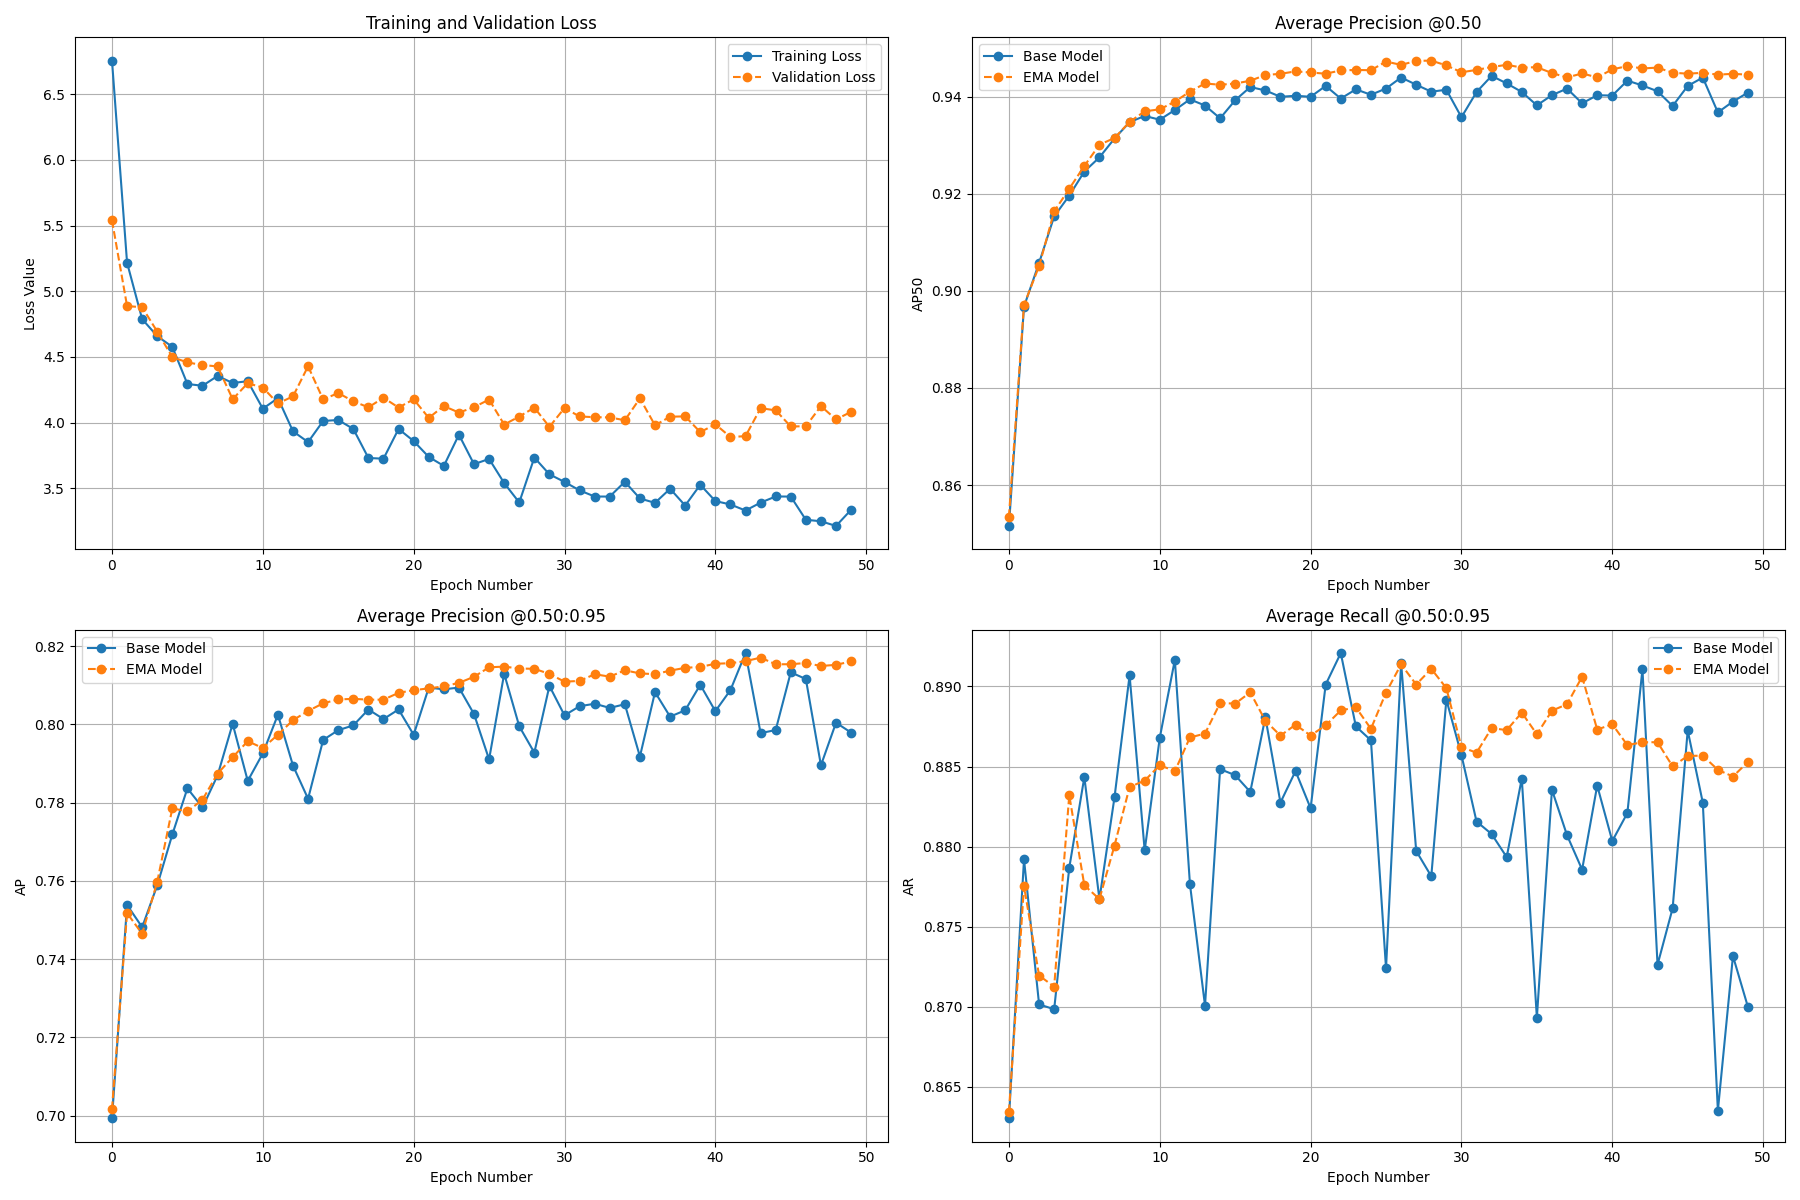

In [19]:
from PIL import Image

Image.open("/content/drive/MyDrive/output/metrics_plot.png")